# Import library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Load dataset

In [ ]:
file_path = '/content/drive/MyDrive/MachineLearningFinal/melb_data_cleaned.xlsx'
data = pd.read_excel(file_path)

# Data processing

In [ ]:
# Select relevant columns for prediction
features = ['Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car',
            'Landsize', 'BuildingArea', 'YearBuilt', 'Regionname',
            'Propertycount', 'Method']
target = 'Price'
data = data[features + [target]]

In [ ]:
# Drop rows with missing values
data = data.dropna()

In [ ]:
# Transform skewed numerical columns
for col in ['Landsize', 'BuildingArea', 'Price']:
    data[col] = np.log1p(data[col])  # Log-transformation

In [ ]:
# Define input features (X) and target (y)
X = data[features]
y = data[target]

In [ ]:
# Preprocess data
categorical_features = ['Type', 'Regionname', 'Method']
numerical_features = [col for col in features if col not in categorical_features]

In [ ]:
# Apply transformations: scaling numerical and encoding categorical data
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

X_preprocessed = preprocessor.fit_transform(X)

# Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Build optimized ANN model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dense(1)  # Output layer
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

# Early stopping

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Train the model

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=500, batch_size=64, callbacks=[early_stopping])

Epoch 1/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 64.1942 - mae: 5.7471 - val_loss: 6.4310 - val_mae: 0.9000
Epoch 2/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.9743 - mae: 1.1445 - val_loss: 4.3759 - val_mae: 0.3476
Epoch 3/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 5.3991 - mae: 0.9382 - val_loss: 3.6649 - val_mae: 0.2978
Epoch 4/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 4.6570 - mae: 0.8729 - val_loss: 3.1348 - val_mae: 0.2601
Epoch 5/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9749 - mae: 0.8170 - val_loss: 2.7673 - val_mae: 0.3115
Epoch 6/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.4936 - mae: 0.7740 - val_loss: 2.3878 - val_mae: 0.2444
Epoch 7/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.1114 - mae: 0.7537 - val_loss: 2.1024 - val_mae: 0.2465
Epoch 8/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7823 - mae: 0.7284 - val_loss: 1.8537 - val_mae: 0.2329
Epoch 9/500
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 7

# Evaluate the model

In [ ]:
import numpy as np

# Chuyển đổi ngược từ log-transformed sang giá trị thực tế
y_test_actual = np.expm1(y_test)  # expm1 = exp(x) - 1
y_pred_actual = np.expm1(y_pred)

# Tính toán lại các chỉ số
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
mse_actual = mean_squared_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mse_actual)
r2_actual = r2_score(y_test_actual, y_pred_actual)

print(f"MAE (actual scale): {mae_actual}")
print(f"MSE (actual scale): {mse_actual}")
print(f"RMSE (actual scale): {rmse_actual}")
print(f"R-squared (actual scale): {r2_actual}")


MAE (actual scale): 205195.23253744454
MSE (actual scale): 114391816405.28386
RMSE (actual scale): 338218.59263689787
R-squared (actual scale): 0.7217968459948899


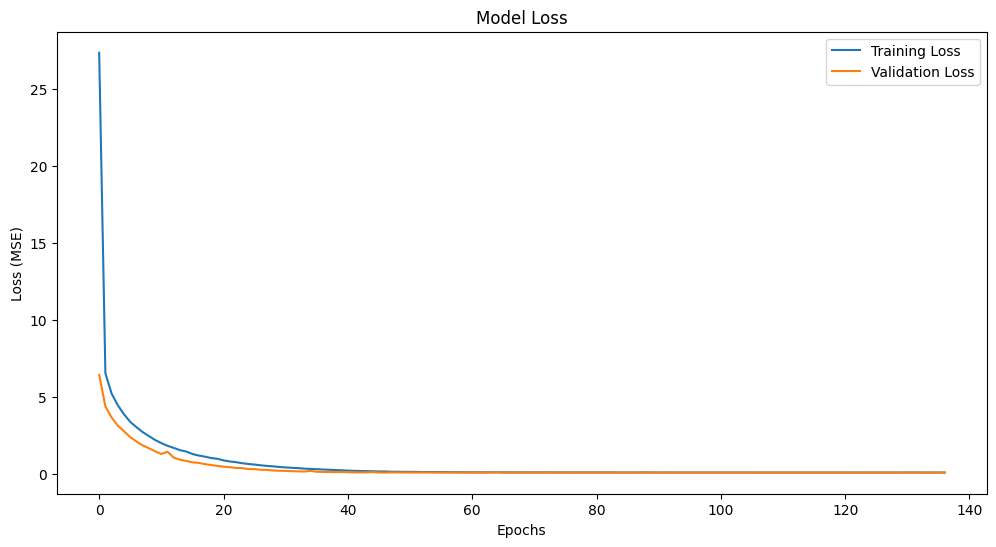

In [ ]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

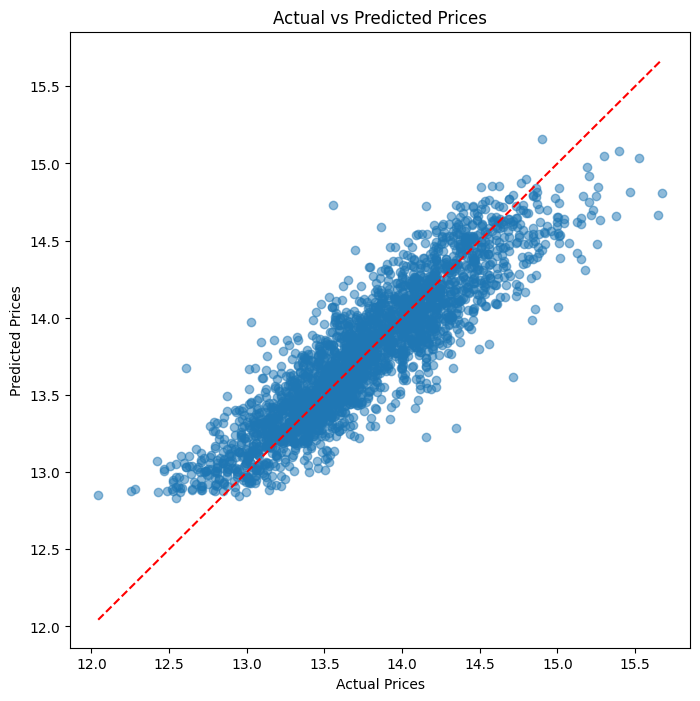

In [ ]:
# Scatter plot for predictions
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()

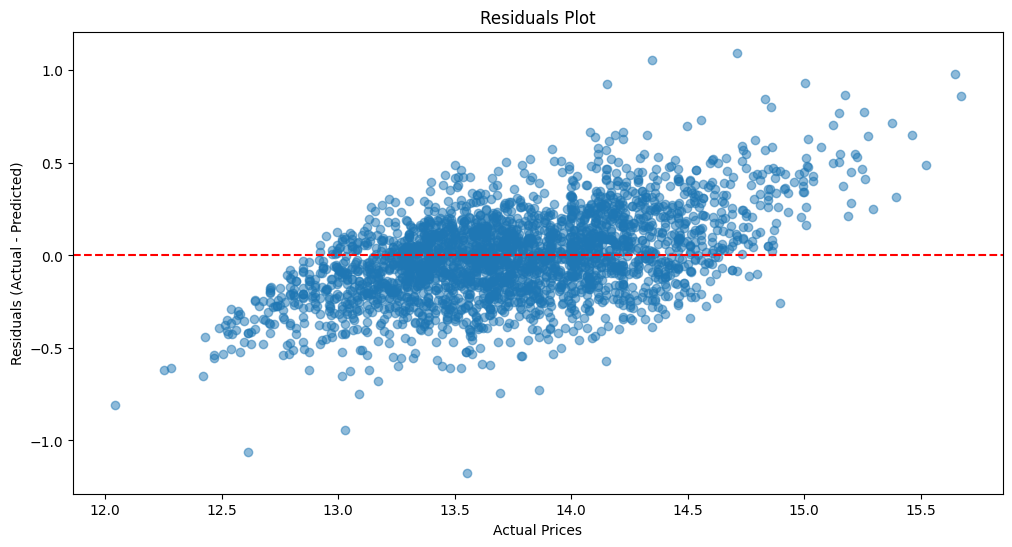

In [ ]:
# Plot residuals
residuals = y_test - y_pred

plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Actual Prices')
plt.ylabel('Residuals (Actual - Predicted)')
plt.show()

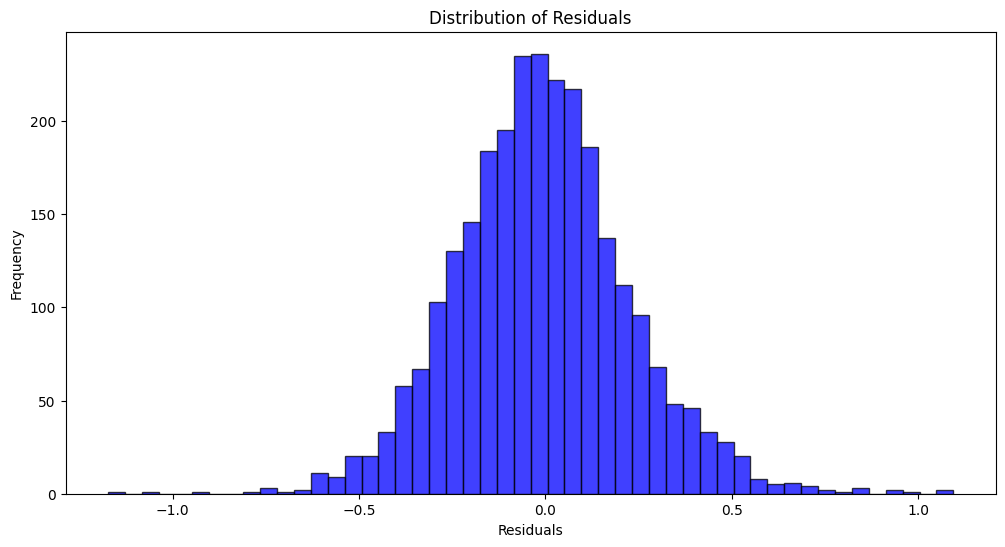

In [ ]:
# Distribution of residuals
plt.figure(figsize=(12, 6))
plt.hist(residuals, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

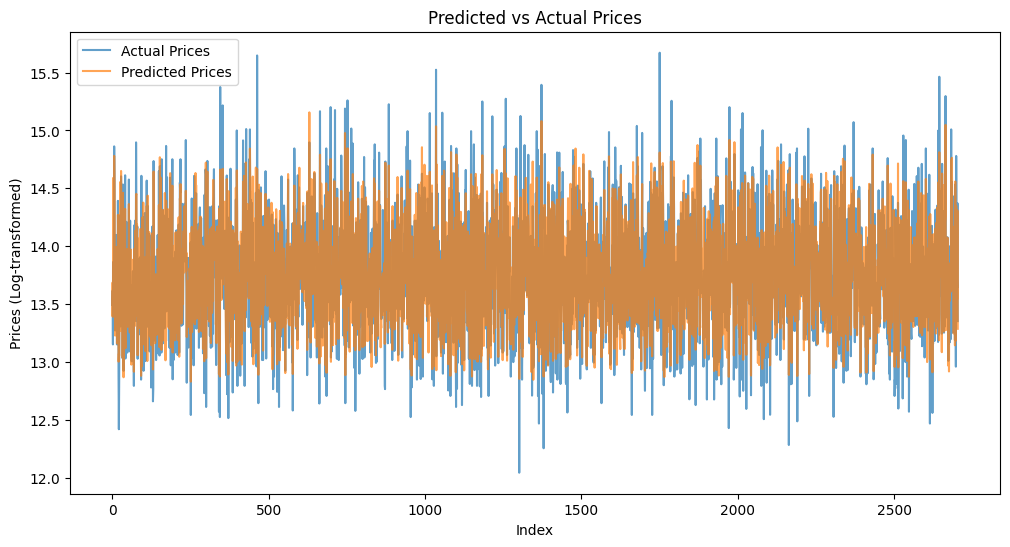

In [ ]:
# Predicted vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual Prices', alpha=0.7)
plt.plot(range(len(y_test)), y_pred, label='Predicted Prices', alpha=0.7)
plt.title('Predicted vs Actual Prices')
plt.xlabel('Index')
plt.ylabel('Prices (Log-transformed)')
plt.legend()
plt.show()